In [1]:
from polar_codes.polar_code import PolarCode
from polar_codes.channels.bpsk_awgn_channel import BpskAwgnChannel
import numpy as np
from numpy import save
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


# Generation of data for training net

In [2]:
n=4
N = 16
K = 8
num_of_data = 2**9
X = np.zeros([num_of_data,N], dtype=np.int64)
Y = np.zeros([num_of_data,K], dtype=np.int64)

In [3]:
def generate(n, K, num_of_data):
    j = 0
    sinrdb = j
    channel = BpskAwgnChannel(sinrdb)
    code = PolarCode(n=n, K=K, construction_method='PW', channel=channel)
    for i in range(0, num_of_data):
        u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8')
        x_message = code.encode(u_message)
        to_message = channel.modulate(x_message)
        from_message = channel.transmit(to_message)
        y_message = channel.demodulate(from_message)
        X[i] = y_message 
        Y[i] = u_message

In [4]:
generate(n, K, num_of_data)

In [5]:
save('0_X.npy', X)
save('0_y.npy', Y)

# Net

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(16,64)
        self.bn1 = nn.BatchNorm1d(64, momentum=.9999)
        self.fc2 = nn.Linear(64,64)
        self.bn2 = nn.BatchNorm1d(64, momentum=.9999)
        self.fc3 = nn.Linear(64,64)
        self.bn3 = nn.BatchNorm1d(64, momentum=.9999)
        self.fc4 = nn.Linear(64,8)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.sigmoid(self.fc4(x))
        return x

# Training

In [7]:
X = np.load('0_X.npy')
Y = np.load('0_y.npy')

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/4, random_state=42)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dnn = Net().to(device)

In [10]:
X_train= torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(Y_train)
Y_test = torch.Tensor(Y_test)

In [11]:
X_test.shape

torch.Size([128, 16])

In [12]:
traindataset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(traindataset, batch_size=32, shuffle=True) 
testdataset = TensorDataset(X_test, Y_test)
testloader = DataLoader(testdataset, batch_size=32, shuffle=True)

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=0.001, weight_decay=0.001)

In [14]:
epochs = 500
train_losses = []
test_losses = []
train_ber = []
test_ber = []
for i in range(epochs):
    running_loss = 0.0
    dnn.train()
    num_of_data = 0
    correct = 0
    ber = 0
    data_size = 0 
    for inputs,labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_of_data += 1
        j_iterate = len(outputs)
        len_of_code = len(outputs[0])
        outputs = (outputs > 0.5).type(torch.int64)
        ber += (outputs != labels).numpy().sum()
        data_size += outputs.numpy().size
    print(f'epoch={i}, train_loss={running_loss/num_of_data}, BER={ber/data_size}')
    train_losses.append(running_loss/num_of_data)
    train_ber.append(ber/data_size)
    data_size = 0
    ber = 0
    num_of_data = 0
    running_loss = 0
    with torch.no_grad():
        dnn.eval()
        for inputs,labels in trainloader:
            outputs = dnn(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            num_of_data += 1
            outputs = (outputs > 0.5).type(torch.int64)
            ber += (outputs != labels).numpy().sum()
            data_size += outputs.numpy().size
    print(f'epoch={i}, test_loss={running_loss/num_of_data}, BER={ber/data_size}')
    test_losses.append(running_loss/num_of_data)
    test_ber.append(ber/data_size)

epoch=0, train_loss=0.7068049808343252, BER=0.470703125
epoch=0, test_loss=0.739061693350474, BER=0.390625
epoch=1, train_loss=0.6405267169078191, BER=0.3720703125
epoch=1, test_loss=0.8503007590770721, BER=0.333984375
epoch=2, train_loss=0.5970009664694468, BER=0.3043619791666667
epoch=2, test_loss=0.5837302009264628, BER=0.2760416666666667
epoch=3, train_loss=0.5678694049517313, BER=0.2682291666666667
epoch=3, test_loss=0.5502436409393946, BER=0.2587890625
epoch=4, train_loss=0.5379853149255117, BER=0.23763020833333334
epoch=4, test_loss=0.5247873018185297, BER=0.22721354166666666
epoch=5, train_loss=0.5096786543726921, BER=0.21061197916666666
epoch=5, test_loss=0.6150152559081713, BER=0.22526041666666666
epoch=6, train_loss=0.4914862886071205, BER=0.20052083333333334
epoch=6, test_loss=0.5393811563650767, BER=0.21126302083333334
epoch=7, train_loss=0.4673655902345975, BER=0.17643229166666666
epoch=7, test_loss=0.4452120785911878, BER=0.1796875
epoch=8, train_loss=0.4492865900198619,

epoch=66, train_loss=0.08322560259451468, BER=0.018880208333333332
epoch=66, test_loss=0.14434816564122835, BER=0.027018229166666668
epoch=67, train_loss=0.08169430463264386, BER=0.0166015625
epoch=67, test_loss=0.2811047031233708, BER=0.0283203125
epoch=68, train_loss=0.07667143549770117, BER=0.014973958333333334
epoch=68, test_loss=0.33469660642246407, BER=0.043619791666666664
epoch=69, train_loss=0.06863527341435353, BER=0.011067708333333334
epoch=69, test_loss=0.3229348746438821, BER=0.029296875
epoch=70, train_loss=0.07306451785067718, BER=0.013346354166666666
epoch=70, test_loss=0.3340105786919594, BER=0.048828125
epoch=71, train_loss=0.07799188420176506, BER=0.016276041666666668
epoch=71, test_loss=0.29558344309528667, BER=0.035807291666666664
epoch=72, train_loss=0.0732872427130739, BER=0.013671875
epoch=72, test_loss=0.07254887310167153, BER=0.018880208333333332
epoch=73, train_loss=0.07599945552647114, BER=0.014322916666666666
epoch=73, test_loss=0.1514967984209458, BER=0.041

epoch=131, train_loss=0.03938035496200124, BER=0.005533854166666667
epoch=131, test_loss=0.12324032622079055, BER=0.039388020833333336
epoch=132, train_loss=0.041315960232168436, BER=0.007161458333333333
epoch=132, test_loss=0.07176286866888404, BER=0.011393229166666666
epoch=133, train_loss=0.043278556782752275, BER=0.006184895833333333
epoch=133, test_loss=0.07508745851616065, BER=0.0078125
epoch=134, train_loss=0.039209320986022554, BER=0.007161458333333333
epoch=134, test_loss=0.5317575903609395, BER=0.0341796875
epoch=135, train_loss=0.04788890822480122, BER=0.009440104166666666
epoch=135, test_loss=0.7477862748006979, BER=0.061197916666666664
epoch=136, train_loss=0.03873837972059846, BER=0.005859375
epoch=136, test_loss=0.4225560010721286, BER=0.025716145833333332
epoch=137, train_loss=0.04207601537927985, BER=0.009440104166666666
epoch=137, test_loss=0.29369847228129703, BER=0.0263671875
epoch=138, train_loss=0.03594061996166905, BER=0.005208333333333333
epoch=138, test_loss=0.

epoch=195, train_loss=0.03521409227202336, BER=0.006510416666666667
epoch=195, test_loss=0.4189852438867092, BER=0.022135416666666668
epoch=196, train_loss=0.03171844920143485, BER=0.004557291666666667
epoch=196, test_loss=0.07286277553066611, BER=0.010091145833333334
epoch=197, train_loss=0.03135609161108732, BER=0.004231770833333333
epoch=197, test_loss=0.045324872713536024, BER=0.007161458333333333
epoch=198, train_loss=0.03860251326113939, BER=0.0087890625
epoch=198, test_loss=0.08652264360959332, BER=0.011393229166666666
epoch=199, train_loss=0.03608777094632387, BER=0.005859375
epoch=199, test_loss=0.05617089352260033, BER=0.0107421875
epoch=200, train_loss=0.034239915975679956, BER=0.005859375
epoch=200, test_loss=0.1588085995366176, BER=0.029296875
epoch=201, train_loss=0.036403209126243986, BER=0.005208333333333333
epoch=201, test_loss=0.0904265424857537, BER=0.016927083333333332
epoch=202, train_loss=0.029985829411695402, BER=0.0035807291666666665
epoch=202, test_loss=0.43663

epoch=262, train_loss=0.031743665070583425, BER=0.005533854166666667
epoch=262, test_loss=0.3170832364509503, BER=0.016276041666666668
epoch=263, train_loss=0.03220516613995036, BER=0.0048828125
epoch=263, test_loss=0.4167751659018298, BER=0.021158854166666668
epoch=264, train_loss=0.028345456424479682, BER=0.004231770833333333
epoch=264, test_loss=0.057063243662317596, BER=0.013997395833333334
epoch=265, train_loss=0.03389951679855585, BER=0.005859375
epoch=265, test_loss=0.8883509325484434, BER=0.064453125
epoch=266, train_loss=0.03118321547905604, BER=0.0035807291666666665
epoch=266, test_loss=0.05165418159837524, BER=0.013671875
epoch=267, train_loss=0.032719136060525976, BER=0.005533854166666667
epoch=267, test_loss=0.06540213013067842, BER=0.006510416666666667
epoch=268, train_loss=0.03054611400390665, BER=0.00390625
epoch=268, test_loss=0.08783539058640599, BER=0.012044270833333334
epoch=269, train_loss=0.02863292582333088, BER=0.0035807291666666665
epoch=269, test_loss=0.184687

epoch=326, train_loss=0.034647413374235235, BER=0.005859375
epoch=326, test_loss=0.36410485580563545, BER=0.036458333333333336
epoch=327, train_loss=0.029140647035092115, BER=0.0032552083333333335
epoch=327, test_loss=0.32094570823634666, BER=0.0244140625
epoch=328, train_loss=0.034630082082003355, BER=0.007161458333333333
epoch=328, test_loss=0.25795102460930747, BER=0.034505208333333336
epoch=329, train_loss=0.02891835873015225, BER=0.0035807291666666665
epoch=329, test_loss=0.157446407712996, BER=0.028971354166666668
epoch=330, train_loss=0.0296766705190142, BER=0.0048828125
epoch=330, test_loss=0.16222951095551252, BER=0.028971354166666668
epoch=331, train_loss=0.031228214657555025, BER=0.005208333333333333
epoch=331, test_loss=0.23984091527139148, BER=0.025065104166666668
epoch=332, train_loss=0.03631383739411831, BER=0.0078125
epoch=332, test_loss=0.09281134139746428, BER=0.016276041666666668
epoch=333, train_loss=0.039001954098542534, BER=0.0087890625
epoch=333, test_loss=0.1985

epoch=390, train_loss=0.03135977421576778, BER=0.007161458333333333
epoch=390, test_loss=0.07720538275316358, BER=0.022786458333333332
epoch=391, train_loss=0.033864012298484646, BER=0.0078125
epoch=391, test_loss=0.29717957057679695, BER=0.017903645833333332
epoch=392, train_loss=0.03398481678838531, BER=0.005859375
epoch=392, test_loss=0.06268315063789487, BER=0.0107421875
epoch=393, train_loss=0.03106315511589249, BER=0.006184895833333333
epoch=393, test_loss=0.050691902016599975, BER=0.0126953125
epoch=394, train_loss=0.029607452762623627, BER=0.006184895833333333
epoch=394, test_loss=0.6514785951003432, BER=0.049479166666666664
epoch=395, train_loss=0.027367240904519956, BER=0.0035807291666666665
epoch=395, test_loss=0.09240043970445792, BER=0.016276041666666668
epoch=396, train_loss=0.032947458482036986, BER=0.006510416666666667
epoch=396, test_loss=0.05620737777402004, BER=0.01953125
epoch=397, train_loss=0.03452626305321852, BER=0.007486979166666667
epoch=397, test_loss=0.13255

epoch=455, test_loss=0.15046055956433216, BER=0.0185546875
epoch=456, train_loss=0.0377728040330112, BER=0.006510416666666667
epoch=456, test_loss=0.0755981644615531, BER=0.017903645833333332
epoch=457, train_loss=0.03329921544839939, BER=0.006184895833333333
epoch=457, test_loss=0.0922687694740792, BER=0.015299479166666666
epoch=458, train_loss=0.03719071252271533, BER=0.008463541666666666
epoch=458, test_loss=0.09824515568713348, BER=0.020182291666666668
epoch=459, train_loss=0.02772084701185425, BER=0.00390625
epoch=459, test_loss=0.28882728579143685, BER=0.0263671875
epoch=460, train_loss=0.03340041947861513, BER=0.006184895833333333
epoch=460, test_loss=0.0701789731780688, BER=0.0107421875
epoch=461, train_loss=0.02993471718703707, BER=0.0048828125
epoch=461, test_loss=0.14516198821365833, BER=0.020182291666666668
epoch=462, train_loss=0.0423086218846341, BER=0.009114583333333334
epoch=462, test_loss=0.14140125705550113, BER=0.031575520833333336
epoch=463, train_loss=0.03239079533

Text(0.5, 1.0, 'Losses')

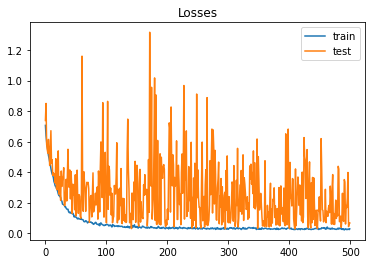

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.title('Losses')

Text(0.5, 1.0, 'BER')

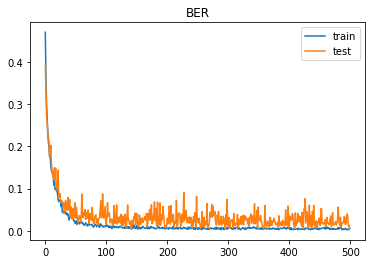

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_ber, label='train')
plt.plot(test_ber, label='test')
plt.legend()
plt.title('BER')

# Example of decoding a code with a trained net

In [17]:
j = 0
sinrdb = j
channel = BpskAwgnChannel(sinrdb)
code = PolarCode(n=n, K=K, construction_method='PW', channel=channel)
u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8')
x_message = code.encode(u_message)
to_message = channel.modulate(x_message)
from_message = channel.transmit(to_message)
y_message = channel.demodulate(from_message)

In [18]:
y_message

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1], dtype=uint8)

In [19]:
out = dnn(torch.tensor(y_message, dtype=torch.float32).unsqueeze(0))

In [20]:
out = (out > 0.5).type(torch.int64).numpy()[0]

In [21]:
out

array([0, 1, 1, 1, 0, 0, 1, 1])

In [22]:
u_message

array([0, 0, 1, 1, 1, 1, 1, 1], dtype=uint8)